In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
df = pd.read_csv("combined_capitalbikeshare_202305_to_202504.csv")

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5F3D280238A782FE,docked_bike,2023-05-12 18:57:59,2023-05-12 19:17:50,3rd & Tingey St SE,31634.0,8th & F St NE,31631.0,38.875010,-77.002400,38.897274,-76.994749,casual
1,97EC218DACB24849,classic_bike,2023-05-23 07:55:29,2023-05-23 08:11:12,Clarendon Blvd & Pierce St,31016.0,15th & L St NW,31276.0,38.893438,-77.076389,38.903649,-77.034918,member
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual


In [5]:
#Looking at member type
df.member_casual.value_counts(sort = True)
#KEY TAKEAWAY: majority of riders are members

member_casual
member    7589882
casual    3845934
Name: count, dtype: int64

In [5]:
#Look at rideable type
df.rideable_type.value_counts(sort = True, normalize = True)

#Filtering the data to ignore docked bike
df = df[(df['rideable_type'] == 'classic_bike') | (df['rideable_type'] == 'electric_bike')]
df[(df['member_casual'] == 'member')].rideable_type.value_counts(sort = True)
# KEY TAKEAWAY: pretty even split between classic and electric bike, even when segmenting by membership status. 
#               docked bike is < 1% of all data, and will be ignored for the rest of the analysis

rideable_type
electric_bike    3985971
classic_bike     3603911
Name: count, dtype: int64

Text(0.5, 0, 'minutes')

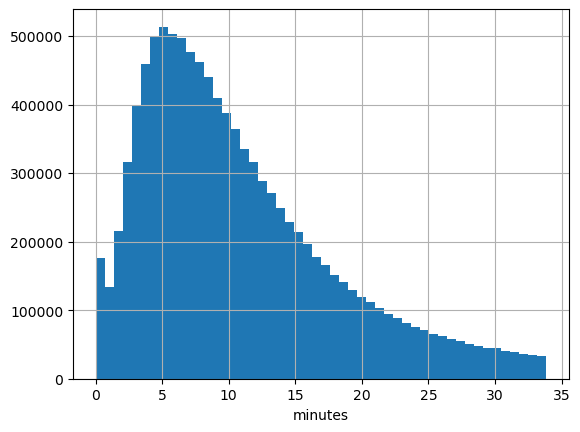

In [7]:
# Look at duration of trips

#Convert to dettime
df[['started_at', 'ended_at']] = df[['started_at', 'ended_at']].apply(pd.to_datetime, format='mixed')
df['duration'] = df['ended_at'] - df['started_at']
df['duration_minutes'] = df['duration'].dt.total_seconds() / 60 #Converting duration to minutes

#Clean up data
df = df[df['duration_minutes'] > 0]
#Removing Outliers
IQR = df['duration_minutes'].quantile(0.75) - df['duration_minutes'].quantile(0.25)
lower_bound = df['duration_minutes'].quantile(0.25) - 1.5 * IQR
upper_bound = df['duration_minutes'].quantile(0.75) + 1.5 * IQR
df = df[(df['duration_minutes'] >= lower_bound) & (df['duration_minutes'] <= upper_bound)]



#Plot
df['duration_minutes'].hist(bins=50)
plt.xlabel('minutes')

#KEY TAKEAWAY: Distribution of ride durations (after removing outliers) has a positive skew, with the median at ~ 8 minutes. 

In [67]:
df['duration_minutes'].describe()

count    8.874378e+06
mean     9.449515e+00
std      5.315740e+00
min      1.050000e-03
25%      5.284817e+00
50%      8.478250e+00
75%      1.276667e+01
max      2.461935e+01
Name: duration_minutes, dtype: float64

In [117]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'duration', 'duration_minutes'],
      dtype='object')

In [11]:
df['ride_id'].value_counts(sort = True).head(10)
# No rider repeats using Capital Bike >2 times. 

ride_id
3EE26EA117CEED93    2
BFE1D91456989165    2
51FB029A6CE41E9A    2
9D3727685F31F9BF    2
D0E2E1A8C10B73DD    2
08DBAFFB21384C21    2
BB082BA2621C35C7    2
F3692297D61157F4    2
CB6881B249B47374    2
7560C440914B50A6    2
Name: count, dtype: int64

In [13]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,duration_minutes
0,5F3D280238A782FE,docked_bike,2023-05-12 18:57:59,2023-05-12 19:17:50,3rd & Tingey St SE,31634.0,8th & F St NE,31631.0,38.875010,-77.002400,38.897274,-76.994749,casual,0 days 00:19:51,19.850000
1,97EC218DACB24849,classic_bike,2023-05-23 07:55:29,2023-05-23 08:11:12,Clarendon Blvd & Pierce St,31016.0,15th & L St NW,31276.0,38.893438,-77.076389,38.903649,-77.034918,member,0 days 00:15:43,15.716667
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member,0 days 00:13:07,13.116667
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member,0 days 00:13:06,13.100000
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual,0 days 00:11:04,11.066667


In [15]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'duration', 'duration_minutes'],
      dtype='object')

In [9]:
df.columns = ['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'x1', 'y1', 'x2', 'y2',
       'member_casual', 'duration', 'duration_minutes']

In [11]:
df['distance'] = 100* np.sqrt(((df['x2']-df['x1'])**2) + ((df['y2']-df['y1'])**2))


In [17]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,x1,y1,x2,y2,member_casual,duration,duration_minutes,distance
1,97EC218DACB24849,classic_bike,2023-05-23 07:55:29,2023-05-23 08:11:12,Clarendon Blvd & Pierce St,31016.0,15th & L St NW,31276.0,38.893438,-77.076389,38.903649,-77.034918,member,0 days 00:15:43,15.716667,4.270958
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member,0 days 00:13:07,13.116667,2.488644
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member,0 days 00:13:06,13.100000,1.777997
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual,0 days 00:11:04,11.066667,2.009159
5,9D72955FF43C2AB4,classic_bike,2023-05-04 15:21:40,2023-05-04 15:24:54,20th & O St NW / Dupont South,31234.0,17th & Corcoran St NW,31214.0,38.908905,-77.044780,38.912100,-77.038700,member,0 days 00:03:14,3.233333,0.686836


<Axes: >

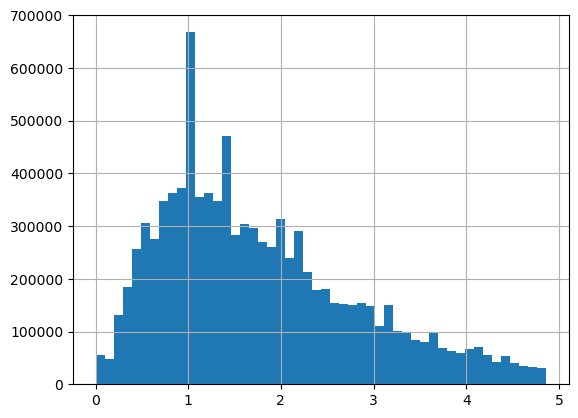

In [13]:
# Look at distance of trips 

#Clean up data
df = df[df['distance'] > 0]
#Removing Outliers
IQR = df['distance'].quantile(0.75) - df['distance'].quantile(0.25)
lower_bound = df['distance'].quantile(0.25) - 1.5 * IQR
upper_bound = df['distance'].quantile(0.75) + 1.5 * IQR
df = df[(df['distance'] >= lower_bound) & (df['distance'] <= upper_bound)]

df['distance'].hist(bins = 50)
# Similar behaviour to duration. positive skew with median at ~ 1.46 km

In [63]:
df['distance'].describe()

count    9.022989e+06
mean     1.670776e+00
std      9.543171e-01
min      1.012126e-05
25%      9.532398e-01
50%      1.463881e+00
75%      2.258856e+00
max      4.244247e+00
Name: distance, dtype: float64

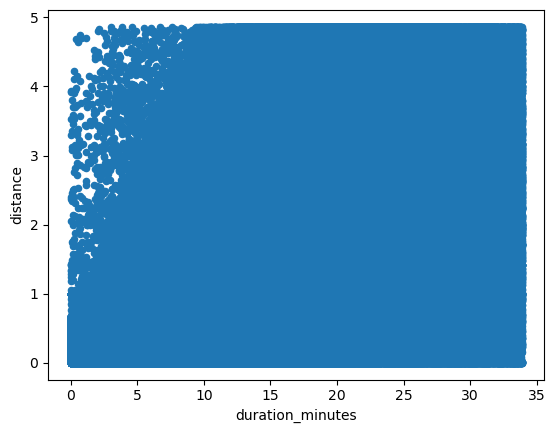

In [19]:
df.plot(x = 'duration_minutes', y = 'distance', kind = 'scatter')
plt.show()
# Too much data :(

In [15]:
df['speed'] = df['distance'] / df['duration_minutes']

In [78]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,x1,y1,x2,y2,member_casual,duration,duration_minutes,distance,speed
0,5F3D280238A782FE,docked_bike,2023-05-12 18:57:59,2023-05-12 19:17:50,3rd & Tingey St SE,31634.0,8th & F St NE,31631.0,38.875010,-77.002400,38.897274,-76.994749,casual,0 days 00:19:51,19.850000,2.354195,0.118599
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member,0 days 00:13:07,13.116667,2.488644,0.189731
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member,0 days 00:13:06,13.100000,1.777997,0.135725
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual,0 days 00:11:04,11.066667,2.009159,0.181551
5,9D72955FF43C2AB4,classic_bike,2023-05-04 15:21:40,2023-05-04 15:24:54,20th & O St NW / Dupont South,31234.0,17th & Corcoran St NW,31214.0,38.908905,-77.044780,38.912100,-77.038700,member,0 days 00:03:14,3.233333,0.686836,0.212424


<Axes: >

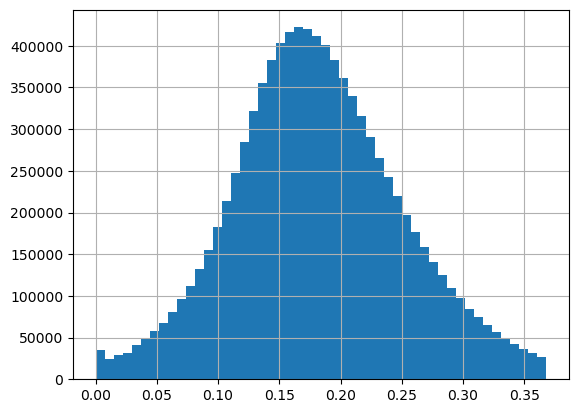

In [17]:
#Look at speed

# Clean up data
df = df[df['speed'] > 0]

# Removing Outliers
IQR = df['speed'].quantile(0.75) - df['speed'].quantile(0.25)
lower_bound = df['speed'].quantile(0.25) - 1.5 * IQR
upper_bound = df['speed'].quantile(0.75) + 1.5 * IQR
df = df[(df['speed'] >= lower_bound) & (df['speed'] <= upper_bound)]

df['speed'].hist(bins = 50)
# Bell curve. Average of 0.2 km/min

In [43]:
df['speed'].describe()

count    9.209922e+06
mean     1.808784e-01
std      6.727330e-02
min      1.672063e-03
25%      1.358809e-01
50%      1.777331e-01
75%      2.246247e-01
max      3.591794e-01
Name: speed, dtype: float64

<Axes: xlabel='duration_segmentation'>

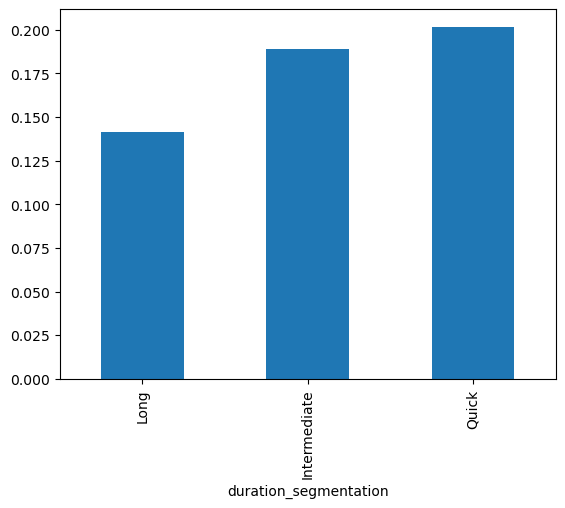

In [19]:
# Speed vs. duration segmentation

#Creating duration segmentation
def duration_seg (x): 
    #Boolean logic
    if x <= 5:
        return 'Quick'
    elif x <= 15: 
        return 'Intermediate'
    else:
        return 'Long'
# Applying funciton to df 
df['duration_segmentation'] = df['duration_minutes'].apply(duration_seg)

#Create new dataframe for groubping duration segmentation and speed
avg_duration_speed = df.groupby('duration_segmentation')['speed'].mean().sort_values(ascending = True)
avg_duration_speed.plot(x = 'duration_segmentation', y = 'speed', kind = 'bar') # plot

#KEY TAKEAWAY: As expected, longer durations had less speeds, and quicker biking sessions had higher speeds. 

<Axes: xlabel='distance_segmentation'>

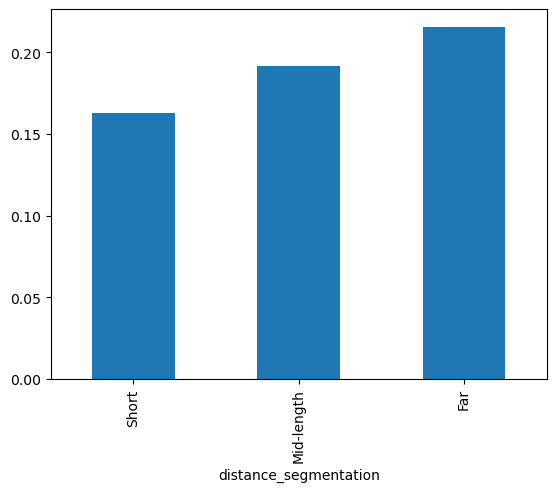

In [23]:
#Speed vs. distance segmentation

#Creating distance segmentation
def distance_seg (y): 
    #Boolean logic
    if y <= 1.5:
        return 'Short'
    elif y <= 3: 
        return 'Mid-length'
    else:
        return 'Far'
# Applying funciton to df 
df['distance_segmentation'] = df['distance'].apply(distance_seg)

#Create new dataframe for grouping distance segmentation and speed
avg_distance_speed = df.groupby('distance_segmentation')['speed'].mean().sort_values(ascending = True)
avg_distance_speed.plot(x = 'distance_segmentation', y = 'speed', kind = 'bar') # plot

#KEY TAKEAWAY: A little unexpected! Shorter distance had lower speeds, while farther distances had greater average speeds.

<Axes: xlabel='distance_segmentation', ylabel='duration_segmentation'>

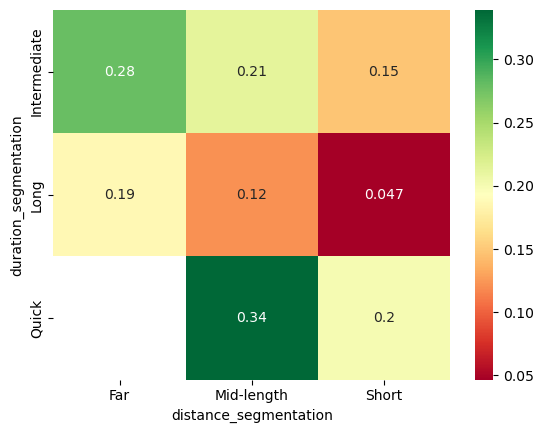

In [25]:
#Relationship between duration and distance segmentation
avg_speed_combined = df.groupby(['duration_segmentation', 'distance_segmentation'])['speed'].mean().unstack()

sns.heatmap(avg_speed_combined, annot = True, cmap='RdYlGn') #Heatmap


In [27]:
#Looking at bike type and speed, distance, and duration
bike_type_seg_avg = df.groupby('rideable_type')[['speed', 'distance', 'duration_minutes']].mean().T
bike_type_seg_median = df.groupby('rideable_type')[['speed', 'distance', 'duration_minutes']].median().T

<Axes: >

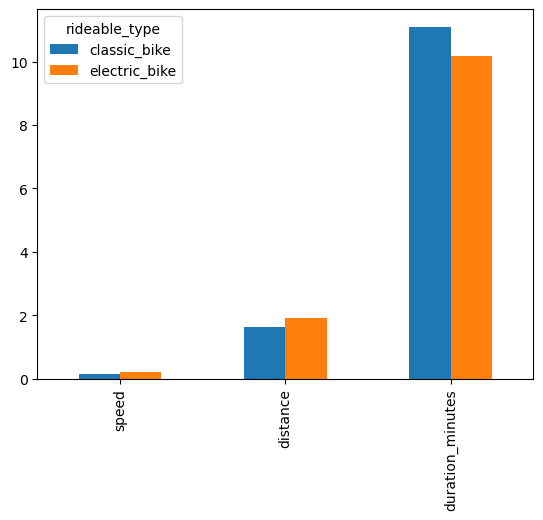

In [55]:
bike_type_seg_avg.plot(kind = 'bar', label = True) # Plot averages

<Axes: >

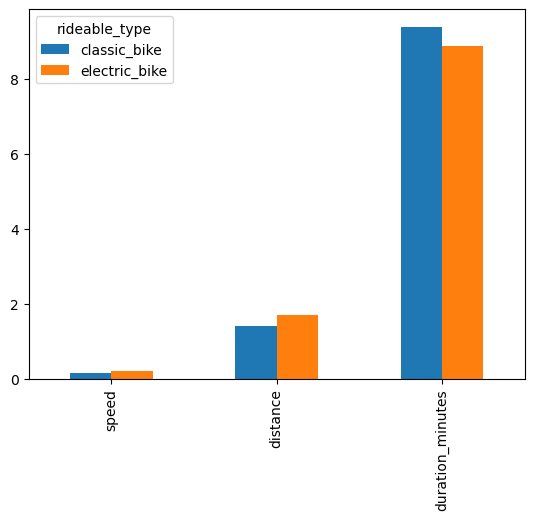

In [29]:
bike_type_seg_median.plot(kind = 'bar', label = True) # Plot medians
# KEY TAKEAWAY: in general, people will ride electric bikes for longer distances and speeed, but they will ride classic bikes
#               for slightly longer durations. Since revenue is deviced by time instead of distance, we should focus on customers
#               who ride classic bikes more than electric bikes. 

In [31]:
#Take a look at station popularity: Exploratory data analysis for understanding distribution

#Most common start and end stations
common_start_stations= df.start_station_name.value_counts(sort = True).head(15)
common_end_stations= df.end_station_name.value_counts(sort=True).head(15)

#Most uncommon start and end stations
uncommon_start_stations= df.start_station_name.value_counts(sort = True).tail(15)
uncommon_end_stations= df.end_station_name.value_counts(sort=True).tail(15)


#All routes (start and end station combinations by popularity
popular_route = df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='count')
common_route =  popular_route.loc[popular_route.groupby('start_station_name')['count'].idxmax()].sort_values(by = 'count', ascending = False)

#Most and least common routes
least_common_route = common_route.tail(15)
most_common_route = common_route.head(15)

#Using merge to find most common stations
high_traffic_station = most_common_route.merge(common_start_stations, on='start_station_name', how='inner') \
    .merge(common_end_stations, on='end_station_name', how='inner')

#Using merge to find least common stations
low_traffic_station = least_common_route.merge(uncommon_start_stations, on='start_station_name', how='inner') \
    .merge(uncommon_end_stations, on='end_station_name', how='inner')

#Using concat for looking at all stations.
common_stations = pd.concat([common_start_stations, common_end_stations])
common_stations = common_stations.head(20)
common_stations


# KEY TAKEAWAY: As shown below, the 2 station names in low traffic have the least amount of rider usage and interaction, while the 2 station names 
#               in the high traffic have the most. 

Columbus Circle / Union Station         96112
New Hampshire Ave & T St NW             89329
15th & P St NW                          78037
14th & V St NW                          71992
5th & K St NW                           71475
1st & M St NE                           68685
M St & Delaware Ave NE                  60464
14th & R St NW                          59252
Massachusetts Ave & Dupont Circle NW    58838
Adams Mill & Columbia Rd NW             57146
14th & Irving St NW                     56480
8th & O St NW                           55311
15th & W St NW                          55219
11th & M St NW                          53341
17th & Corcoran St NW                   52473
Columbus Circle / Union Station         95662
New Hampshire Ave & T St NW             87643
15th & P St NW                          78208
5th & K St NW                           73201
14th & V St NW                          70096
Name: count, dtype: int64

In [33]:
station_start = df.groupby(['start_station_name', 'x1', 'y1']).size().reset_index(name='count')
station_end = df.groupby(['end_station_name', 'x2', 'y2']).size().reset_index(name='count')

station_start.columns = ['name', 'lat', 'long', 'count']
station_end.columns = ['name', 'lat', 'long', 'count']

combined_stations = pd.concat([station_start, station_end])

combined_stations = combined_stations.groupby(['name', 'lat', 'long'])['count'].sum()

combined_stations = combined_stations.sort_values(ascending=False)
combined_stations = combined_stations.head(20)
combined_stations


name                                                 lat        long      
Columbus Circle / Union Station                      38.896960  -77.004930    174921
New Hampshire Ave & T St NW                          38.915544  -77.038252    158403
15th & P St NW                                       38.909801  -77.034427    140139
14th & V St NW                                       38.917764  -77.032096    125786
1st & M St NE                                        38.905697  -77.005483    122397
Massachusetts Ave & Dupont Circle NW                 38.910100  -77.044400    108638
M St & Delaware Ave NE                               38.905691  -77.003201    108035
14th & R St NW                                       38.913046  -77.032008    105174
8th & O St NW                                        38.908640  -77.022770     98928
15th & W St NW                                       38.919018  -77.034449     98384
17th & Corcoran St NW                                38.912100  -77.038700 

In [105]:
combined_stations.to_csv('combined_stations.csv')

In [33]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'x1', 'y1', 'x2', 'y2', 'member_casual', 'duration',
       'duration_minutes', 'distance', 'speed', 'duration_segmentation'],
      dtype='object')

In [230]:
low_traffic_station

,start_station_name,end_station_name,count_x,count_y,count
0,Monroe St & E Park Dr,Herndon Metro South,3,8,4


In [228]:
high_traffic_station

,start_station_name,end_station_name,count_x,count_y,count
0,15th & P St NW,New Hampshire Ave & T St NW,3731,78037,87643
1,New Hampshire Ave & T St NW,15th & P St NW,3613,89329,78208


In [232]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,x1,y1,x2,y2,member_casual,duration,duration_minutes,distance,speed,duration_segmentation,distance_segmentation
1,97EC218DACB24849,classic_bike,2023-05-23 07:55:29,2023-05-23 08:11:12,Clarendon Blvd & Pierce St,31016.0,15th & L St NW,31276.0,38.893438,-77.076389,38.903649,-77.034918,member,0 days 00:15:43,15.716667,4.270958,0.271747,Long,Far
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member,0 days 00:13:07,13.116667,2.488644,0.189731,Intermediate,Mid-length
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member,0 days 00:13:06,13.100000,1.777997,0.135725,Intermediate,Mid-length
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual,0 days 00:11:04,11.066667,2.009159,0.181551,Intermediate,Mid-length
5,9D72955FF43C2AB4,classic_bike,2023-05-04 15:21:40,2023-05-04 15:24:54,20th & O St NW / Dupont South,31234.0,17th & Corcoran St NW,31214.0,38.908905,-77.044780,38.912100,-77.038700,member,0 days 00:03:14,3.233333,0.686836,0.212424,Quick,Short


In [35]:
#Revenue Analysis

#Define pricing model - numbers are based off Capital Bikeshare website
def pricing (bike, member, duration): 
    #Boolean logic
    if member == 'member': 
        if bike == 'classic_bike': 
            return duration * 0.05
        elif bike == 'electric_bike':
            return duration * 0.1
    elif member == 'casual': 
        if bike == 'classic_bike': 
            return 1+ duration * 0.05
        elif bike == 'electric_bike':
            return 1+ duration * 0.15

#Vectorize function for row-by-row operations
vectorized_pricing = np.vectorize(pricing)
df['revenue'] = vectorized_pricing(df['rideable_type'], df['member_casual'], df['duration_minutes']) # Calculate revenue

In [37]:
#most profitable routes
profit_route = df.groupby(['start_station_name', 'end_station_name']).agg( earnings =('revenue', 'mean'), time =('duration_minutes', 'mean'), num_trips=('revenue', 'count'), start_lat=('x1', 'first'), start_long=('y1', 'first'), end_lat=('x2', 'first'), end_long=('y2', 'first')) 
profit_route = profit_route.loc[profit_route.groupby('start_station_name')['earnings'].idxmax()].sort_values(by = ['num_trips', 'earnings', 'time'], ascending = [False, False, False])

In [41]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'x1', 'y1', 'x2', 'y2', 'member_casual', 'duration',
       'duration_minutes', 'distance', 'speed', 'duration_segmentation',
       'distance_segmentation', 'revenue'],
      dtype='object')

In [39]:
profit_route = profit_route.head(20)
profit_route

,,earnings,time,num_trips,start_lat,start_long,end_lat,end_long
start_station_name,end_station_name,,,,,,,
18th St & Pennsylvania Ave NW,M St & New Jersey Ave SE,4.100396,22.682317,40,38.899285,-77.041573,38.876219,-77.004169
Lamont & Mt Pleasant NW,Georgia Ave & Dahlia St NW,4.060393,21.254210,31,38.931942,-77.038738,38.976061,-77.026747
Traville Gateway Dr & Gudelsky Dr,Traville Gateway Dr & Gudelsky Dr,3.086058,14.394231,26,39.093698,-77.202505,39.093783,-77.202501
Blueridge Ave & Elkin St,Blueridge Ave & Elkin St,2.070580,8.798313,26,39.043263,-77.050174,39.043130,-77.050060
King St Metro North / Cameron St,National Harbor Carousel,3.453825,25.478729,25,38.806934,-77.059784,38.785900,-77.016700
13th & H St NE,2nd & V St SW / James Creek Marina,3.709257,20.080601,20,38.900668,-76.988015,38.863743,-77.013814
15th & W St NW,4th & East Capitol St NE,3.407165,28.177502,20,38.919018,-77.034449,38.889955,-77.000349
North Bethesda Metro,North Bethesda Metro,2.200525,12.661824,20,39.047489,-77.112821,39.047530,-77.112870
Duke St & John Carlyle St,Virginia Theological Seminary,3.012917,13.419444,18,38.804470,-77.060820,38.820152,-77.093879


In [49]:
profit_route.to_csv('map_route.csv')

In [37]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'x1', 'y1', 'x2', 'y2', 'member_casual', 'duration',
       'duration_minutes', 'distance', 'speed', 'duration_segmentation',
       'revenue'],
      dtype='object')

In [246]:
#Save new dataframe
df.to_csv('new_df.csv')

In [63]:
profit_route = profit_route.reset_index()

In [93]:
df['day_of_week'] = df['started_at'].dt.day_name()
df['hour'] = df['started_at'].dt.hour
df['quarter'] = 'Q' + df['started_at'].dt.quarter.astype(str)

filtered_df = df[
    (df.rideable_type == 'electric_bike') &
    (df.member_casual == 'casual') &
    (df['start_station_name'].isin(profit_route['start_station_name'])) &
    (df['end_station_name'].isin(profit_route['end_station_name'])) &
    (df['quarter'].isin(['Q2', 'Q3'])) &
    (df['day_of_week'].isin(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])) &
    (df['hour'] >= 6) & (df['hour'] < 20)]


<Axes: xlabel='started_at', ylabel='revenue'>

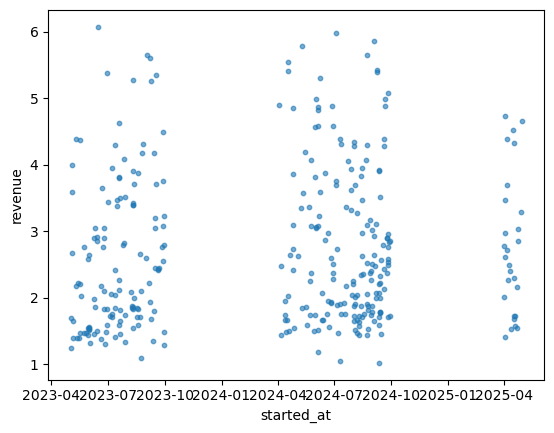

In [101]:
filtered_df.plot.scatter(x='started_at', y='revenue', s=10, alpha=0.6)
